In [ ]:
# Akshita Pathak 102203796
!pip install transformers datasets rouge-score torch pandas numpy tqdm

In [ ]:
import numpy as np
import pandas as pd
from rouge_score import rouge_scorer
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
import torch
import time
import matplotlib.pyplot as plt

models = [
    "facebook/bart-large-cnn",
    "t5-base",
    "google/pegasus-cnn_dailymail",
    "sshleifer/distilbart-cnn-12-6",
    "facebook/bart-large-xsum"
]

# evaluation criteria and their weights
criteria = {
    'rouge1_f1': {'weight': 0.25, 'impact': 'positive'},
    'rouge2_f1': {'weight': 0.25, 'impact': 'positive'},
    'rougeL_f1': {'weight': 0.25, 'impact': 'positive'},
    'inference_time': {'weight': 0.15, 'impact': 'negative'},
    'model_size': {'weight': 0.10, 'impact': 'negative'}
}

def load_test_data(num_samples=50):
    """Load sample data from CNN/DailyMail dataset"""
    from datasets import load_dataset
    dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")
    return dataset.select(range(num_samples))

def evaluate_model(model_name, test_data):
    """Evaluate a single model on test data"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    summarizer = pipeline("summarization", model=model_name, device=0 if device == "cuda" else -1)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    results = {
        'rouge1_f1': [],
        'rouge2_f1': [],
        'rougeL_f1': [],
        'inference_time': [],
        'model_size': []
    }

    model_size = summarizer.model.num_parameters() * 4 / (1024 * 1024)

    for item in tqdm(test_data, desc=f"Evaluating {model_name}"):
        try:
            start_time = time.time()
            summary = summarizer(item['article'][:1024], max_length=130, min_length=30)[0]['summary_text']
            inference_time = time.time() - start_time
            scores = scorer.score(item['highlights'], summary)
            results['rouge1_f1'].append(scores['rouge1'].fmeasure)
            results['rouge2_f1'].append(scores['rouge2'].fmeasure)
            results['rougeL_f1'].append(scores['rougeL'].fmeasure)
            results['inference_time'].append(inference_time)
            results['model_size'].append(model_size)
        except Exception as e:
            print(f"Error processing item with {model_name}: {str(e)}")
            continue

    return {k: np.mean(v) for k, v in results.items()}

def apply_topsis(decision_matrix, criteria):
    """Apply TOPSIS method"""
    normalized = decision_matrix.copy()
    for column in normalized.columns:
        normalized[column] = normalized[column] / np.sqrt((normalized[column]**2).sum())
    for column in normalized.columns:
        normalized[column] = normalized[column] * criteria[column]['weight']
    ideal_best = []
    ideal_worst = []
    for column in normalized.columns:
        if criteria[column]['impact'] == 'positive':
            ideal_best.append(normalized[column].max())
            ideal_worst.append(normalized[column].min())
        else:
            ideal_best.append(normalized[column].min())
            ideal_worst.append(normalized[column].max())
    
    s_best = np.sqrt(((normalized - ideal_best)**2).sum(axis=1))
    s_worst = np.sqrt(((normalized - ideal_worst)**2).sum(axis=1))
    performance_score = s_worst / (s_best + s_worst)
    return performance_score

def main():
    print("Loading test data...")
    test_data = load_test_data(num_samples=20)  # Using 20 samples for demonstration

    print("Evaluating models...")
    results = {}
    for model_name in models:
        try:
            results[model_name] = evaluate_model(model_name, test_data)
            print(f"Completed evaluation of {model_name}")
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            continue

    decision_matrix = pd.DataFrame(results).T

    print("Applying TOPSIS...")
    performance_scores = apply_topsis(decision_matrix, criteria)

    rankings = pd.DataFrame({
        'Model': decision_matrix.index,
        'TOPSIS Score': performance_scores
    }).sort_values('TOPSIS Score', ascending=False)

    return rankings, decision_matrix

def save_results(rankings, decision_matrix):
    rankings.to_csv('model_rankings.csv', index=False)
    plt.figure(figsize=(12, 6))
    plt.bar(rankings['Model'], rankings['TOPSIS Score'])
    plt.xticks(rotation=45)
    plt.title('Model Rankings by TOPSIS Score')
    plt.tight_layout()
    plt.savefig('model_rankings.png')
    decision_matrix.to_csv('model_metrics.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

Loading test data...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Evaluating models...


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Evaluating facebook/bart-large-cnn: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

Completed evaluation of facebook/bart-large-cnn


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0
Evaluating t5-base: 100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


Completed evaluation of t5-base


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use cuda:0
Evaluating google/pegasus-cnn_dailymail: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Completed evaluation of google/pegasus-cnn_dailymail


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0
Evaluating sshleifer/distilbart-cnn-12-6: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Completed evaluation of sshleifer/distilbart-cnn-12-6


config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Evaluating facebook/bart-large-xsum: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Completed evaluation of facebook/bart-large-xsum
Applying TOPSIS...

Final Rankings:
                                                       Model  TOPSIS Score
facebook/bart-large-cnn              facebook/bart-large-cnn      0.787153
sshleifer/distilbart-cnn-12-6  sshleifer/distilbart-cnn-12-6      0.764769
facebook/bart-large-xsum            facebook/bart-large-xsum      0.416406
t5-base                                              t5-base      0.350565
google/pegasus-cnn_dailymail    google/pegasus-cnn_dailymail      0.226898


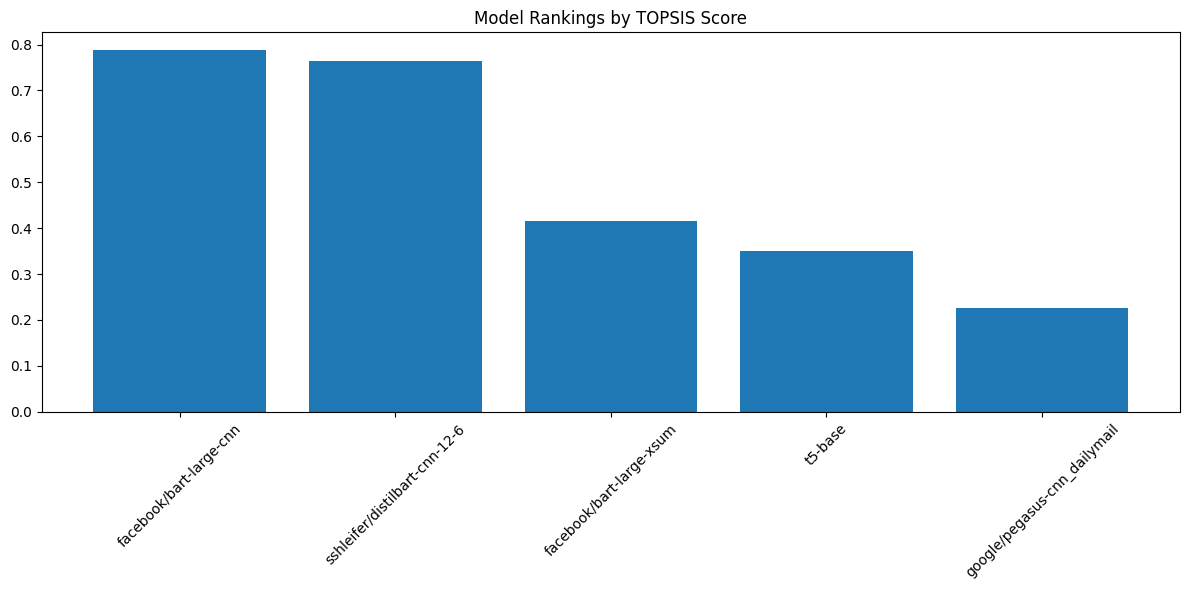

In [ ]:
rankings, metrics = main()
print("\nFinal Rankings:")
print(rankings)
save_results(rankings, metrics)